***Author: Ritwika VPS, ritwika@ucmerced.edu***  
***Written: October 9, 2025***  
###### (see below for modifications log)  

This script investigates the memory problem in the context of Collective Intelligence (CI) vs. Collective Memory (CM) by comparing how the coverage of a task consisting of TaskSize number of memory bits compares between groups that are fixed/'stable' and have performed the task before (CM groups) and groups consisting of agents randomly pooled from groups that have previously performed the task (CI groups). That is, in the latter case, the agents were part of a group that has solved the task but have not themselves solved the task together. CM and CI groups have the same number of agents with each agent having the same memory size (i.e., number of memory bits that can be stored by the agent).

> Note that there can be further complexities added to this framework, including variable memory for agents (i.e., not all agents have the same number of memory bits), noise or error in memory storage or retrival (which can further vary across agents), and memory bits that are stored exactly (when the bit is solved by the agent) and memory bits that are stored with error (when the agent observes another agent solving the bit). Here, however, we choose to stick to the much simpler case where memory bits are stored and recalled perfectly, there is only one type of memory storage (without distinguishing between observed or solved bits), and all agents have the same memory size.  

Now, consider that the total memory of the task is given by TaskSize, the number of agents i a group is N_a, and the memory size for each agent is m_a. From the perspective of the computational algorithm, there are 2 broad cases:  
- Case I. ***TaskSize $\ge$ N<sub>a</sub>m<sub>a</sub>***: This corresponds to the case where there are no redundant memory bits. That is, no memory bit of the task is stored more than once in a group of agents. In fact, if the TaskSize is less than the total memory in a group, some bits are necessarily excluded (which, in turn, would correspond to the task being partially solved by the group, which we include in the simulations for illustrative purposes) (*LeqGroupMem*).  
- Case II. ***TaskSize $<$ N<sub>a</sub>m<sub>a</sub>***: This corresponds to the case where there *are* agent memory bits that allow for redundant storage of task memory bits. Because the total memory in a group is greater than the TaskSize, some memory bits of the task are stored more than once. We go into more detail on this more below.

The case where TaskSize $\leq$ N<sub>a</sub>m<sub>a</sub> necessarily means that the task is exhaustively covered by the group because there are at least as many bits available across the group as there are bits in the task, and we are assuming that a group of agents completing the task means that the task is fully solved (and therefore, stored in the agents' memory). While this is straightforward when TaskSize is exactly equal to N<sub>a</sub>m<sub>a</sub>, there are various ways in which this can be realised when TaskSize $<$ N<sub>a</sub>m<sub>a</sub> (and especially as N<sub>a</sub>m<sub>a</sub> $>>$ TaskSize). 

For case II, there are further two broad cases:  
- Case IIa. When there is no redundancy (i.e., when some agent memory bits are not filled):  
    - Case IIa.1. when the memory bits are assigned randomly such that all agents randomly get assigned some bits (*GreaterGroupMem_NoRedundRandom*). E.g., for a task of size 5, A1 = [1, NaN, 4]; A2 = [2, NaN, NaN]; A3 = [3, 5, NaN]
    - Case IIa.2: first come, first serve, such that depending on how much redundancy exists, some agents get assigned no bits (*GreaterGroupMem_NoRedund1Come1Serve*). E.g., for a task of size 5, A1 = [1, 2, 4]; A2 = [5, 3, NaN]; A3 = [NaN, NaN, NaN]
    - Case IIa.3: when the memory bits are assigned sequentially (to agents) and randomly such that depending on how many bits of redundancy exists, agents have roughly equal number of memory bits as NaN (*GreaterGroupMem_NoRedundRandSeq*). E.g., for a task of size 5, A1 = [1, 4, NaN]; A2 = [2, 3, NaN]; A3 = [5, NaN, NaN]
- Case IIb. When there *is* redundancy, such that once all bits for the task are assigned to agents, leftover agent memory bits are assigned more bits of the task, such that task bits are not uniquely assigned to agents. If the same task memory bit is not allowed to be stored by an agent more than once, 'redundant' versions of cases IIa.1--3 collapse into a single redundant case, with any agent bits $>$ TaskSize remain unfilled. 

For case IIb, if the redundant agent memory bits (i.e., the bits that remain unfilled after exhaustively covering the TaskSize, as outlined in Case IIa) are allowed to be filled such that an agent may store more than one copy of the same task memory bit, then cases IIa.1--3 are at least somehwat distinct from each other.  

Another potential layer of complexity can be introduced by each agent drawing task memory bits independently such that unless m_a $\geq$ TaskSize, there is no guarantee of the task being exhaustively covered. Within this scenario, there can further be cases where unfilled memory bits after this initial drawing (for m_a $>$ TaskSize) are filled by another draw from the task memory bits or not. 

Note that storing the same bit multiple times vs. leaving agent memory bits unfilled are equivalent within the context of what we are measuring, since we are only interested in how stable vs. mixed groups are able to represent the task, and a given task bit being stored once or multiple times within an agent's memory here does not change the outcome.  

> From the perspective of how the outcomes changes, the above cases can be summarised as follows (a total of 9 variants):  
> - Drawing task memory bits without replacement (i.e., task is covered exhaustively with limits based on values of m_a, N_a, and TaskSize):  
>    - No redundancy (unfilled agent memory bits remain unfilled) + task covered as exhaustively as possible (contingent upon how N_a, m_a, and TaskSize are related): 3 variants (Case I + Cases IIa.1--3). 
>    - With redundancy (unfilled agent memory bits are filled with more task bits) + exhaustive + no repeated bits at the agent level: 1 variant (Case I + Case IIb). 
>    - With redundancy (unfilled agent memory bits are filled with more task bits) + exhaustive + repeated bits allowed at the agent level: 3 variants (Case I + Case IIa.1--3).  
> - Drawing task memory bits with replacement (i.e., each agent draws m_a bits from the total TaskSize number of memory bits and as such, this can be potentially non-exhaustive upto m_a $<$ TaskSize): 2 variants (repeated bits allowed OR not at the agent level). 

In this script, we will consider the (no redundancy + exhaustive) cases as well as the case of (with redundancy + exhaustive + no repeated bits), for a total of 4 variants. Within these, we will treat the (No redundancy + exhaustive) case with random assignment (Case I + Case IIa.1) as the primary case.

In [597]:
#Import necessary modules
import numpy as np
import matplotlib.pyplot as plt #plotting library
import matplotlib.ticker as ticker #for customizing axis ticks
import seaborn as sbn #statistical data visualization library
import pandas as pd #data manipulation and analysis library
import os
import multiprocessing as mxp
from functools import partial #for parallelising
from tqdm import tqdm #for progress bar

In [598]:
def DistributeTask_LeqGroupMem(TaskSize, N_a, m_a):
    """
    This function distributes the task (consisting of TaskSize number of bits) among N_a agents (consisting of a group), each with memory size of m_a bits such that N_a*m_a <= TaskSize.
    That is, the total number of memory bits pooled across agents in a group can at most only fully cover the TaskSize such that there are no redundant bits of memory.

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.

    Returns:
    AgentBits (2d numpy array): each row corresponds to an agent and the elements in the row correspond to the memory bits assigned to that agent.
    NumExcludedBits (int): Number of bits of the task not covered by the agents in the group.
    """
    TotalCoverage = N_a*m_a # Total memory coverage across agents
    if TotalCoverage > TaskSize: #error check 
        raise ValueError("Total memory across agents exceeds TaskSize such that there will be empty agent memory bits. Please ensure N_a * m_a <= TaskSize.")
    
    MemoryPerm = np.random.permutation(range(TaskSize)) + 1 # Randomly permute the memory vector (obtained as range(TaskSize)) (+ 1 because Python indexes from 0)
    
    if TotalCoverage == TaskSize: #if total memory across agents exactly covers the Task
        AgentBits = np.reshape(MemoryPerm, (N_a, m_a)) #Reshape the permuted memory vector into an array of N_a rows and m_a columns, such that each row corresponds to 
        #the memory bits assigned to an agent
        NumExcludedBits = np.size(MemoryPerm) - np.size(AgentBits) #Number of bits excluded 

        #error checks
        if NumExcludedBits != 0: 
            raise ValueError("Number of bits excluded should be zero when TotalCoverage is exactly equal to TaskSize.")
        
        if np.size(np.setdiff1d(MemoryPerm, AgentBits)) != 0: 
            raise ValueError("The setdiff of the AgentBits array and the MemoryPerm array/list should be empty (because the task is fully covered by pooled agent memory in the group).")
        
    elif TotalCoverage < TaskSize: #if total memory across agents is less than TaskSize
        MemoryPermTrimmed = MemoryPerm[0:TotalCoverage] #Trim the permuted memory vector to only include the first TotalCoverage number of bits
        #(note that this will actually index from 0 to TotalCoverage-1 because Python indexes from 0)
        
        AgentBits = np.reshape(MemoryPermTrimmed, (N_a, m_a)) #Reshape the trimmed permuted memory vector into an appropriately shaped array (see above)
        NumExcludedBits = np.size(MemoryPerm) - np.size(AgentBits) #Number of bits excluded (should be TaskSize - TotalCoverage in this case)
        
         #error checks
        if NumExcludedBits != (TaskSize - TotalCoverage):
            raise ValueError("Number of bits excluded should be equal to TaskSize - TotalCoverage when TotalCoverage is less than TaskSize.")
        elif NumExcludedBits < 0:
            raise ValueError("Number of bits excluded should not be negative.")
    
    return AgentBits, NumExcludedBits

In [599]:
def DistributeTask_GreaterGroupMem_NoRedundRandom(TaskSize, N_a, m_a):
    """ 
    This function distributes the task (consisting of TaskSize number of bits) among N_a agents in a group, each with memory size of m_a bits such that N_a*m_a > TaskSize. That is, the
    total number of memory bits pooled across agents in a group exceeds the TaskSize such that there are redundant bits of memory. 

    Task memory distribution is done such that bits are assigned randomly to agents. This is accomplished by padding the range(TaskSize) vector with NaNs such that the total length 
    is now equal to N_a*m_a (the total number of memory bits available in the group), randomly permuting this padded vector, and reshaping it into an array of shape (N_a, m_a) such 
    that each row corresponds to an agent and the elements in the row correspond to the memory bits assigned to that agent. By doing this, it is ensured that all agents get assigned 
    some bits (strictly speaking this would depend on how much redundancy exists, such that when N_a*m_a >> TaskSize, some agents may still get assigned no bits). Since there is no 
    redundancy, unfilled agent memory bits are assigned NaN.

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.

    Returns:
    AgentBits (2d numpy array): each row corresponds to an agent and the elements in the row correspond to the memory bits assigned to that agent.
    NumExcludedBits (int): Number of bits of the task not covered by the agents in the group.
    """
    
    TotalCoverage = N_a*m_a # Total memory coverage across agents
    if TotalCoverage <= TaskSize: #error check 
        raise ValueError("Total memory across agents is less than TaskSize such that there cannot be empty agent memory bits. Please ensure N_a * m_a > TaskSize.")
    
    PaddedMemoryPerm = np.random.permutation(range(TotalCoverage)) + 1# Randomly permute the padded memory vector (obtained as range(TotalCoverage)) (+ 1 because Python indexes from 0)
    PaddedMemoryPerm = PaddedMemoryPerm.astype(np.float64) # Convert to float to allow NaN assignment (see below)
    PaddedMemoryPerm[PaddedMemoryPerm > TaskSize] = np.nan #Assign NaN to all memory bits that exceed TaskSize 
    AgentBits = np.reshape(PaddedMemoryPerm, (N_a, m_a)) #Reshape the permuted memory vector into an array of N_a rows and m_a columns, such that each row corresponds to 
    #the memory bits assigned to an agent

    #error checks
    TrueMemoryVec = np.arange(TaskSize) + 1 #The true memory vector (i.e., the range(TaskSize) vector) (+ 1 because Python indexes from 0)
    #print(TrueMemoryVec) #print(np.setdiff1d(TrueMemoryVec, AgentBits))
    if np.size(np.setdiff1d(TrueMemoryVec, AgentBits)) != 0: #note that setdiff1d automatically removes NaNs
        raise ValueError("The setdiff of the AgentBits array and TrueMemoryVec should be empty (because the task is fully covered by pooled agent memory in the group).")
    
    NumExcludedBits = 0 #Number of bits excluded (should be zero in this case) (and we know this because we have done error checks)
    
    return AgentBits, NumExcludedBits

In [600]:
def DistributeTask_GreaterGroupMem_NoRedund1Come1Serve(TaskSize, N_a, m_a):
    """ 
    This function distributes the task (consisting of TaskSize number of bits) among N_a agents in a group, each with memory size of m_a bits such that N_a*m_a > TaskSize. That is, the
    total number of memory bits pooled across agents in a group exceeds the TaskSize such that there are redundant bits of memory. 

    Task memory distribution is done such that bits are assigned randomly and sequentially to agents. That is, the first agent receives a randomised bit, then the second agent receives
    a randomised bit from the remaining bits, and so on and so forth till all task memory bits are assigned. This is accomplished by randomly permuting the range(TaskSize) 
    bits, and if there are any leftover bits, those are randomly assigned to the second agent and so on and so forth. This is accomplished by randomly permuting the range(TaskSize) 
    vector and *then* padding it with NaNs such that the total length is now equal to N_a*m_a (the total number of memory bits available in the group). This is followed by sequentially 
    assigning bits from this permuted vector to each agent by reshaping the permuted vector into an array of shape (N_a, m_a) such that each row corresponds to an agent and the elements
    in the row correspond to the memory bits assigned to that agent. By doing this, the memory distribution is such that the first one or more agents are biased to store more (or all)
    bits of the task. Since there is no redundancy, unfilled agent memory bits are assigned NaN. 

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.

    Returns:
    AgentBits (2d numpy array): each row corresponds to an agent and the elements in the row correspond to the memory bits assigned to that agent.
    NumExcludedBits (int): Number of bits of the task not covered by the agents in the group.
    """
    
    TotalCoverage = N_a*m_a # Total memory coverage across agents
    if TotalCoverage <= TaskSize: #error check 
        raise ValueError("Total memory across agents is less than TaskSize such that there cannot be empty agent memory bits. Please ensure N_a * m_a > TaskSize.")
    
    MemoryPerm = np.random.permutation(range(TaskSize)) + 1 # Randomly permute the memory vector (obtained as range(TaskSize)) (+ 1 because Python indexes from 0)
    ArrayToPad = np.full((TotalCoverage-TaskSize,),np.nan) #Create a 1d array of NaNs to pad the permuted memory vector with. Here, the argument (TotalCoverage-TaskSize,) 
    #creates a 1D array of length (TotalCoverage-TaskSize). That is, there will be (TotalCoverage-TaskSize) number of NaNs in this array.
    PaddedMemoryPerm = np.concatenate((MemoryPerm, ArrayToPad)) #Pad the permuted memory vector with NaNs such that its length is equal to TotalCoverage
    AgentBits = np.reshape(PaddedMemoryPerm, (N_a, m_a)) #Reshape the permuted memory vector 
    
    #error checks
    TrueMemoryVec = np.arange(TaskSize) + 1 #The true memory vector (i.e., the range(TaskSize) vector) (+ 1 because Python indexes from 0)
    if len(PaddedMemoryPerm) != TotalCoverage: 
        raise ValueError("The length of the padded memory vector should be equal to TotalCoverage.")
    
    if len(MemoryPerm) != TaskSize:
        raise ValueError("The length of the permuted memory vector should be equal to TaskSize.")
    
    if np.size(np.setdiff1d(TrueMemoryVec, AgentBits)) != 0: #note that setdiff1d automatically removes NaNs
        raise ValueError("The setdiff of the AgentBits array and TrueMemoryVec should be empty (because the task is fully covered by pooled agent memory in the group).")
    
    NumExcludedBits = 0 #Number of bits excluded (should be zero in this case) (and we know this because we have done error checks)
    
    return AgentBits, NumExcludedBits

In [601]:
def DistributeTask_GreaterGroupMem_NoRedundRandSeq(TaskSize, N_a, m_a):
    """ 
    This function distributes the task (consisting of TaskSize number of bits) among N_a agents in a group, each with memory size of m_a bits such that N_a*m_a > TaskSize. That is, the
    total number of memory bits pooled across agents in a group exceeds the TaskSize such that there are redundant bits of memory. 

    Task memory distribution is done such that bits are assigned randomly to agents on a first come first serve basis. That is, the first agent receives a randomised assortment of task 
    bits, and if there are any leftover bits, those are randomly assigned to the second agent and so on and so forth. This is accomplished by randomly permuting the range(TaskSize) 
    vector and *then* padding it with NaNs such that the total length is now equal to N_a*m_a (the total number of memory bits available in the group). This is followed by sequentially 
    assigning bits from this permuted vector to each agent by reshaping the permuted vector into an array of shape (m_a, N_a) and *then* transposing it such that each row corresponds 
    to an agent and the elements in the row correspond to the memory bits assigned to that agent. By doing this (distribution by reshaping with rows = agent memory size and columns = 
    number of agents, *followed* by transposing) the memory distribution is such that the agents are sequentially and randomly assigned bits. 

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.

    Returns:
    AgentBits (2d numpy array): each row corresponds to an agent and the elements in the row correspond to the memory bits assigned to that agent.
    NumExcludedBits (int): Number of bits of the task not covered by the agents in the group.
    """
    
    #The only difference between this function and DistributeTask_GreaterGroupMem_NoRedund1Come1Serve is that here, the reshaping is done with rows = agent memory size and
    #columns = number of agents, followed by transposing. So, we can simply use the DistributeTask_GreaterGroupMem_NoRedund1Come1Serve function and then transpose the output.
    AgentBits, NumExcludedBits = DistributeTask_GreaterGroupMem_NoRedund1Come1Serve(TaskSize, m_a, N_a)
    AgentBits = AgentBits.T #Transpose to get the desired shape

    return AgentBits, NumExcludedBits

In [602]:
def GetAggregateAgentBitsForNgroups(TaskSize, N_a, m_a, N_groups, MemoryDistCondition):
    """
    This function generates the aggregated AgentBits array (AggregAgentBits) for N_groups. Here, AggregAgentBits is a 2D numpy array generated by vertically stacking the AgentBits 
    arrays obtained from each group. See relevant functions used for more details

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.
    N_groups (int): Number of groups.
    MemoryDistCondition (str): Condition for task memory distribution. 
        Possible values are: "GreaterGroupMem_NoRedundRandom", "GreaterGroupMem_NoRedund1Come1Serve", "GreaterGroupMem_NoRedundRandSeq".

    Returns:
    AggregAgentBits: aggregated AgentBits array for N_groups. 
    TrueExcludedBits: number of excluded bits for stable groups
    """
    TotalCoverage = N_a*m_a # Total memory coverage across agents

    AggregAgentBits = np.empty((0, m_a))  # Initialize an empty NumPy array with m_a columns (since each agent has m_a memory bits). We will use this to sequentially store
    #the AgentBits arrays obtained from each group, and then use this aggregated array to create shufflef groups
    ExcludedBitsArray = np.zeros((N_groups,))

    if TotalCoverage <= TaskSize: #Case when total task coverage is at most the same as TaskSize
        for i in range(N_groups): #Go through each group
            AgentBits, ExcludedBitsArray[i] = DistributeTask_LeqGroupMem(TaskSize, N_a, m_a) #Get AgentBits array for each group
            AggregAgentBits = np.vstack([AggregAgentBits, AgentBits]) #Append the AgentBits array to the AggregAgentBits array
    elif TotalCoverage > TaskSize: #Case when total task coverage exceeds TaskSize
        for i in range(N_groups): #Go through each group and test for different conditions
            if MemoryDistCondition == "GreaterGroupMem_NoRedundRandom":
                AgentBits, ExcludedBitsArray[i] = DistributeTask_GreaterGroupMem_NoRedundRandom(TaskSize, N_a, m_a) 
            elif MemoryDistCondition == "GreaterGroupMem_NoRedund1Come1Serve":
                AgentBits, ExcludedBitsArray[i] = DistributeTask_GreaterGroupMem_NoRedund1Come1Serve(TaskSize, N_a, m_a) 
            elif MemoryDistCondition == "GreaterGroupMem_NoRedundRandSeq":
                AgentBits, ExcludedBitsArray[i] = DistributeTask_GreaterGroupMem_NoRedundRandSeq(TaskSize, N_a, m_a) 
            else:
                raise ValueError("Invalid MemoryDistCondition. Possible values are: GreaterGroupMem_NoRedundRandom, GreaterGroupMem_NoRedund1Come1Serve, GreaterGroupMem_NoRedundRandSeq.")
            
            AggregAgentBits = np.vstack([AggregAgentBits, AgentBits]) #Append the AgentBits array to the AggregAgentBits array

    if np.size(np.unique(ExcludedBitsArray)) > 1:
        raise ValueError('Number of excluded bits varies across groups. This should not happen')
    
    TrueExcludedBits = np.unique(ExcludedBitsArray)[0] #get the number of excluded bits for stable groups
        
    return AggregAgentBits, TrueExcludedBits

In [603]:
def GetShuffledGroups(TaskSize, N_a, m_a, N_groups, MemoryDistCondition):
    """ 
    This function generates the aggregate array for N_groups of N_a agents each with memory size m_a, shuffles the groups, and returns the shuffled groups. See relevant functions 
    used for more details.

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.
    N_groups (int): Number of groups to simulate.
    MemoryDistCondition (string): Memory distribution condition. We only use this when the TaskSize is less than the total memory across agents in a group (N_a*m_a > TaskSize).
        Possible values are: GreaterGroupMem_NoRedundRandom, GreaterGroupMem_NoRedund1Come1Serve, GreaterGroupMem_NoRedundRandSeq.

    Returns:
    ShuffledGroups: array with the shuffled groups, such that each consecutive group of N_a rows correspond to one shuffled group
    TrueExcludedBits: number of excluded bits for stable groups
    """

    #Get aggregated AgentBits array for N_groups as well as the number of excluded bits for stable groups
    AggregAgentBits, TrueExcludedBits = GetAggregateAgentBitsForNgroups(TaskSize, N_a, m_a, N_groups, MemoryDistCondition)

    NumRows = np.shape(AggregAgentBits)[0] #Get the number of rows in the AggregAgentBits array (this will be the actual length, not indexed from 0. So, a value of 3 will mean there
    #are 3 rows, not 2)
    ShuffledGroupInds = np.random.permutation(range(NumRows)) #Get a random permutation of the row indices of the AggregAgentBits array
    #Note that because we are using range(NumRows), the indices are indexed from 0. So, if NumRows = 3, the possible indices are [0, 1, 2], which will then be randomly permuted
    ShuffledGroups = AggregAgentBits[ShuffledGroupInds] #Shuffle the groups by indexing the AggregAgentBits array with the randomly permuted row indices

    if NumRows != np.shape(ShuffledGroups)[0]:
        raise ValueError("Number of rows in ShuffledGroups should be the same as that in AggregAgentBits.")

    return ShuffledGroups, TrueExcludedBits

In [604]:
def GetMeanAndStdExcludedBits(TaskSize, N_a, m_a, N_groups, MemoryDistCondition):
    """ 
    This function returns the mean and standard deviation of the number of excluded bits across N_groups by computing the number of excluded bits for each shuffled group and 
    then taking the average and the std deviation. Meanwhile, for stable groups, the number of excluded bits remains fixed.

    Inputs:
    TaskSize (int): memory size of task.
    N_a (int): Number of agents in a group.
    m_a (int): Memory capacity of each agent.
    N_groups (int): Number of groups to simulate.
    MemoryDistCondition (string): Memory distribution condition. We only use this when the TaskSize is less than the total memory across agents in a group (N_a*m_a > TaskSize).
        Possible values are: GreaterGroupMem_NoRedundRandom, GreaterGroupMem_NoRedund1Come1Serve, GreaterGroupMem_NoRedundRandSeq.

    Returns:
    MeanExcludedBits, StdExcludedBits: mean and std deviation of the number of excluded bits across N_groups
    Stable_ExcludedBits: number of excluded bits for stable groups
    """

    ShuffledGroups, Stable_ExcludedBits = GetShuffledGroups(TaskSize, N_a, m_a, N_groups, MemoryDistCondition)
    
    TrueMemoryVec = np.arange(TaskSize) + 1 #The true memory vector (i.e., the range(TaskSize) vector) (+ 1 because Python indexes from 0)
    ExcludedBitsArray = np.zeros((N_groups,)) #Initialize an array to store the number of excluded bits across N_groups number of runs

    for i in range(N_groups):
        CurrShuffledGroup = ShuffledGroups[i*N_a:(i+1)*N_a, :] #Get the current shuffled group by indexing the ShuffledGroups array.
        #Note that when python indexes from i to j, what we actually get is i to (j-1), which is why the above indexing works (which is wild and a lil confusing to me)
        NumExcludedBits_ShuffledGroup = np.size(np.setdiff1d(TrueMemoryVec, CurrShuffledGroup)) #Get the number of excluded bits for the current shuffled group
        ExcludedBitsArray[i] = NumExcludedBits_ShuffledGroup 
    
    MeanExcludedBits = np.mean(ExcludedBitsArray) #Mean of excluded bits across N_groups number of runs (setdiff already takes care of NaNs )
    StdExcludedBits = np.std(ExcludedBitsArray) #Standard deviation of excluded bits across N_groups number of runs
    
    return MeanExcludedBits, StdExcludedBits, Stable_ExcludedBits

In [605]:
# """
# This function is a wrapper for the GetMeanAndStdExcludedBits function to allow parallel processing. 

# Inputs: - i: index of the first level directories (i)
#         - OpFilePathPrefixStr: the output file path prefix string to which the identifier of the i-th first level directory is added, followed by '.csv'
#         - FirstLvlDirs: the list of first level directories
#         - FirstLvlDirPaths: the list of path objects pointing to paths paths to first level directories
#         - ReqCategs: the list of required categories
#         - DataStrLists: the nested list of strings with data identifiers
#         - ColNames: the column names for the output csv file
# """
# def WrapperFn_GetMeanAndStdExcludedBits(i, OpFilePathPrefixStr,FirstLvlDirs,FirstLvlDirPaths,ReqCategs,DataStrLists,ColNames):

#     OpFilePath = Path(OpFilePathPrefixStr + FirstLvlDirs[i] + '.csv') #create the output file path by adding the i-th first level directory to the 
#     #output file path prefix string
#     CurrPath = FirstLvlDirPaths[i] #Set current path to the i-th first level directory path object
#     pathsList = GetListOfReqPaths(CurrPath, ReqCategs) #get list of paths with relevant data
#     #print(pathsList) #print(CurrPath) #print(OpFilePath)
#     ParseXmlAndWriteOpToFile(pathsList,ReqCategs,DataStrLists,OpFilePath,ColNames,LoggerFilePath) #parse each relevant xml file and write output to file, line by line

In [606]:
def GetCIvsCMstatsForParamSweep(TaskSize, N_a_vec, m_a_vec, N_g, MemoryDistCondition):

    #Initialise arrays
    NumAgents = len(N_a_vec)
    NumAgentMemBits = len(m_a_vec)
    MeanExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan) #np.zeros((len(TaskMem_To_Na), len(TaskMem_To_ma)))
    StdExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan)
    Stable_ExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan)

    #print(type(MeanExcludedBitsArray), type(StdExcludedBitsArray), type(Stable_ExcludedBitsArray))

    for i_Na in tqdm(range(NumAgents), total=NumAgents):
        for i_ma in range(NumAgentMemBits):

            N_a = N_a_vec[i_Na] #Number of agents in a group
            m_a = m_a_vec[i_ma] #Memory size of each agent

            #print(N_a, m_a)
            MeanTemp, StdTemp, StableExcBitsTemp = GetMeanAndStdExcludedBits(TaskSize, N_a, m_a, N_g, MemoryDistCondition)

            MeanExcludedBitsArray[i_Na,i_ma] = MeanTemp
            StdExcludedBitsArray[i_Na,i_ma] = StdTemp
            Stable_ExcludedBitsArray[i_Na,i_ma] = StableExcBitsTemp

    #print(type(MeanTemp), type(StdTemp), type(StableExcBitsTemp))
    return MeanExcludedBitsArray, StdExcludedBitsArray, Stable_ExcludedBitsArray

In [607]:
# def GetCIvsCMstatsForParamSweep_wParallel(TaskSize, N_a_vec, m_a_vec, N_g, MemoryDistCondition):

#     NumAgents = len(N_a_vec)
#     NumAgentMemBits = len(m_a_vec)

#     #Initialise arrays
#     MeanExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan) #np.zeros((len(TaskMem_To_Na), len(TaskMem_To_ma)))
#     StdExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan)
#     Stable_ExcludedBitsArray = np.full((NumAgents, NumAgentMemBits), np.nan)

#     #print(type(MeanExcludedBitsArray), type(StdExcludedBitsArray), type(Stable_ExcludedBitsArray))

#     for i_Na in range(NumAgents):
#         for i_ma in range(NumAgentMemBits):

#             N_a = N_a_vec[i_Na] #Number of agents in a group
#             m_a = m_a_vec[i_ma] #Memory size of each agent

#             #print(N_a, m_a)
#             MeanTemp, StdTemp, StableExcBitsTemp = GetMeanAndStdExcludedBits(TaskSize, N_a, m_a, N_g, MemoryDistCondition)

#             MeanExcludedBitsArray[i_Na,i_ma] = MeanTemp
#             StdExcludedBitsArray[i_Na,i_ma] = StdTemp
#             Stable_ExcludedBitsArray[i_Na,i_ma] = StableExcBitsTemp

#     #print(type(MeanTemp), type(StdTemp), type(StableExcBitsTemp))
#     return MeanExcludedBitsArray, StdExcludedBitsArray, Stable_ExcludedBitsArray

In [608]:
"""
Run the simulation
"""

#Set parameters
N_g = 5000 #Number of groups to simulate
TaskSize = 15 #Memory size of task
N_a = np.arange(2, 2*TaskSize, 1)
m_a = np.arange(2, (2*TaskSize)+1, 1)
MemoryDistCondition = 'GreaterGroupMem_NoRedundRandom'

#Run the simulation for given parameters
MeanExcludedBitsArray, StdExcludedBitsArray, Stable_ExcludedBitsArray = GetCIvsCMstatsForParamSweep(TaskSize, N_a, m_a, N_g, MemoryDistCondition)


100%|██████████| 28/28 [32:31<00:00, 69.69s/it] 


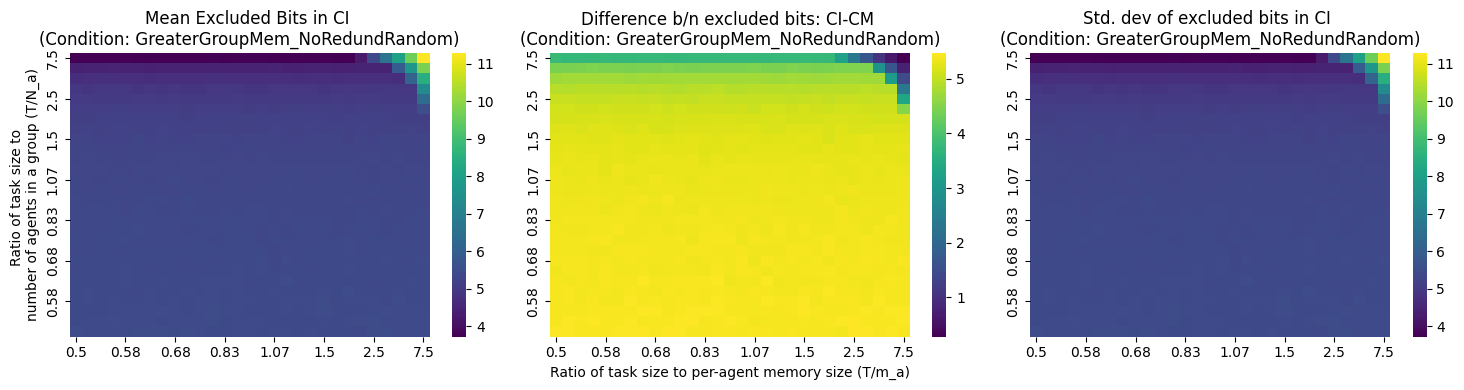

In [612]:
"""
Plotting
"""
#Set up dataframes to plot: we want the x and y axis to be the ratio of TaskSize to the number of per-agent memory bit and the number of agents respectively. 
MeanData = pd.DataFrame(MeanExcludedBitsArray, index=np.around(TaskSize/N_a,2), columns=np.around(TaskSize/m_a,2)) #mean excluded bits
MeanDiffData = pd.DataFrame(MeanExcludedBitsArray-Stable_ExcludedBitsArray, index=np.around(TaskSize/N_a,2), columns=np.around(TaskSize/m_a,2)) #difference between CI vs CM performance
#as the difference between the number of excluded bits for shuffled groups and stable groups
StdData = pd.DataFrame(MeanExcludedBitsArray, index=np.around(TaskSize/N_a,2), columns=np.around(TaskSize/m_a,2))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sbn.heatmap(MeanData, ax=axes[0], cmap='viridis', fmt=".1f", linewidths=0,  xticklabels=4,  yticklabels=4); axes[0].invert_xaxis() # Invert the x-axis
# ax.invert_yaxis() # Invert the y-axis
# majorFormatter_x = FormatStrFormatter('%0.0f') # For whole numbers on x-axis
# majorFormatter_y = FormatStrFormatter('%0.1f') # For one decimal place on y-axis
# ax.xaxis.set_major_formatter(majorFormatter_x)
# ax.yaxis.set_major_formatter(majorFormatter_y)
axes[0].set_title('Mean Excluded Bits in CI \n(Condition: {})'.format(MemoryDistCondition)) 
axes[0].set_ylabel('Ratio of task size to \nnumber of agents in a group (T/N_a)')

sbn.heatmap(MeanDiffData, ax=axes[1], cmap='viridis', fmt=".1f", linewidths=0,  xticklabels=4,  yticklabels=4); axes[1].invert_xaxis() # Invert the x-axis
axes[1].set_title('Difference b/n excluded bits: CI-CM \n(Condition: {})'.format(MemoryDistCondition)) 
axes[1].set_xlabel('Ratio of task size to per-agent memory size (T/m_a)')

sbn.heatmap(StdData, ax=axes[2], cmap='viridis', fmt=".1f", linewidths=0,  xticklabels=4,  yticklabels=4); axes[2].invert_xaxis() # Invert the x-axis
axes[2].set_title('Std. dev of excluded bits in CI \n(Condition: {})'.format(MemoryDistCondition)) 

plt.tight_layout(); plt.show()


In [610]:
## This is just a cell testing all the functions that do the distribution of task memory to agents. Feel free to uncomment to run/see the outputs
#AgentBits_Less, NumExcludedBits_Less = DistributeTask_LeqGroupMem(20, 3, 5)
# print(AgentBits_Less)
# print(NumExcludedBits_Less)
#AgentBits_Eq, NumExcludedBits_Eq = DistributeTask_LeqGroupMem(15, 3, 5)
# print(AgentBits_Eq)
# print(NumExcludedBits_Eq)
#AgentBits_NoRedRand, NumExcludedBits_NoRedRand = DistributeTask_GreaterGroupMem_NoRedundRandom(12, 3, 5)
# print(AgentBits_NoRedRand)
# print(NumExcludedBits_NoRedRand)
#AgentBits_NoRed11, NumExcludedBits_NoRed11= DistributeTask_GreaterGroupMem_NoRedund1Come1Serve(12, 3, 5)
# print(AgentBits_NoRed11)
# print(NumExcludedBits_NoRed11)
#AgentBits_NoRedRandSeq, NumExcludedBits_NoRedRandSeq = DistributeTask_GreaterGroupMem_NoRedundRandSeq(12, 3, 5)
# print(AgentBits_NoRedRandSeq)
# print(NumExcludedBits_NoRedRandSeq)